# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import (cross_val_score, GridSearchCV)
from sklearn.metrics import (confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             classification_report)

np.random.seed(23)

In [2]:
X_train = pd.read_csv('../data/x_train_processed.csv')
X_test = pd.read_csv('../data/x_test_processed.csv')
y_train = pd.read_csv('../data/y_train_processed.csv')
y_test = pd.read_csv('../data/y_test_processed.csv')

In [3]:
print(X_train.shape, '\n', 
      y_train.shape, '\n', 
      X_test.shape, '\n', 
      y_test.shape)

(8718, 31) 
 (8718, 1) 
 (2180, 31) 
 (2180, 1)


# Logistic Regression Model

In [4]:
logreg_params = {'penalty': ['l1', 'l2'], 
                 'solver': ['liblinear', 'saga']
                }

logreg_gridsearch = GridSearchCV(LogisticRegression(max_iter=5000), 
                                 logreg_params, 
                                 cv=5)

logreg_gridsearch.fit(X_train, y_train.values.ravel())

print(logreg_gridsearch.best_estimator_)
print(logreg_gridsearch.best_params_)

print('\nBaseline: 35%')

print('\nBest Score:', round(logreg_gridsearch.best_score_, 4))
print('Test Score:', round(logreg_gridsearch.score(X_test, y_test.values.ravel()), 4))

LogisticRegression(max_iter=5000, penalty='l1', solver='saga')
{'penalty': 'l1', 'solver': 'saga'}

Baseline: 35%

Best Score: 0.5635
Test Score: 0.5784


In [5]:
logreg = LogisticRegression(max_iter=5000, 
                            penalty='l1', 
                            random_state=73, 
                            solver='saga')

logreg.fit(X_train, y_train.values.ravel())

train_scores = cross_val_score(logreg, X_train, y_train.values.ravel())
test_scores = cross_val_score(logreg, X_test, y_test.values.ravel())

print('Baseline: 35%\n')

print('Train scores:', train_scores)
print('Mean:', round(train_scores.mean(), 3))
print('Stdev:', round(2 * train_scores.std(), 3), '\n')

print('Test scores:', test_scores)
print('Mean:', round(test_scores.mean(), 3))
print('Stdev:', round(2 * test_scores.std(), 3), '\n')

Baseline: 35%

Train scores: [0.56766055 0.55848624 0.55619266 0.56052783 0.57487091]
Mean: 0.564
Stdev: 0.014 

Test scores: [0.5733945  0.62385321 0.56880734 0.58486239 0.57568807]
Mean: 0.585
Stdev: 0.04 



# Coefficient Interpretation

In [6]:
coeffs = ['coeffs_' + str(i) for i in list(range(3))]
coeffs_df = pd.DataFrame()

for i, coeff in enumerate(coeffs):

    coeff = pd.DataFrame(list(zip(X_train.columns, np.expm1(logreg.coef_[i]))), 
                         columns=['features_'+str(i), 'coeff_'+str(i)])
    
    coeff['abs_'+str(i)] = round(abs(coeff['coeff_'+str(i)]), 2)
    coeff['coeff_'+str(i)] = round(coeff['coeff_'+str(i)], 2)
    
    coeff = coeff.sort_values('abs_'+str(i), ascending=False) 
    coeff.reset_index(drop=True, inplace=True)
    
    coeffs_df = pd.concat([coeffs_df, coeff], axis=1)

coeffs_df.head(10)

,features_0,coeff_0,abs_0,features_1,coeff_1,abs_1,features_2,coeff_2,abs_2
0,state_Pennsylvania,7.03,7.03,state_Tennessee,-0.36,0.36,state_New Mexico,1.57,1.57
1,state_Oregon,-0.76,0.76,state_Vermont,0.31,0.31,state_North Carolina,1.54,1.54
2,aircrafts_2,-0.75,0.75,seniors,-0.10,0.10,number_volunteers,1.32,1.32
3,number_volunteers,-0.74,0.74,state_New Jersey,0.09,0.09,state_Washington,1.03,1.03
4,state_New Mexico,-0.73,0.73,state_Nevada,-0.06,0.06,aircrafts_1,0.85,0.85
5,state_Colorado,0.57,0.57,state_Utah,-0.02,0.02,state_Oregon,0.76,0.76
6,state_Wyoming,0.49,0.49,daylight,0.01,0.01,aircrafts_2,0.76,0.76
7,mental,-0.46,0.46,state_Washington,0.00,0.00,area_type_urban_rural,-0.34,0.34
8,area_type_urban_rural,0.45,0.45,state_Wyoming,0.00,0.00,children,-0.34,0.34
9,state_Washington,-0.35,0.35,state_Pennsylvania,0.00,0.00,mental,0.31,0.31


# Metrics

              precision    recall  f1-score   support

      0-11hr       0.64      0.72      0.68       737
     11-32hr       0.42      0.31      0.36       695
32hours-7day       0.62      0.69      0.65       748

    accuracy                           0.58      2180
   macro avg       0.56      0.57      0.56      2180
weighted avg       0.56      0.58      0.57      2180



''

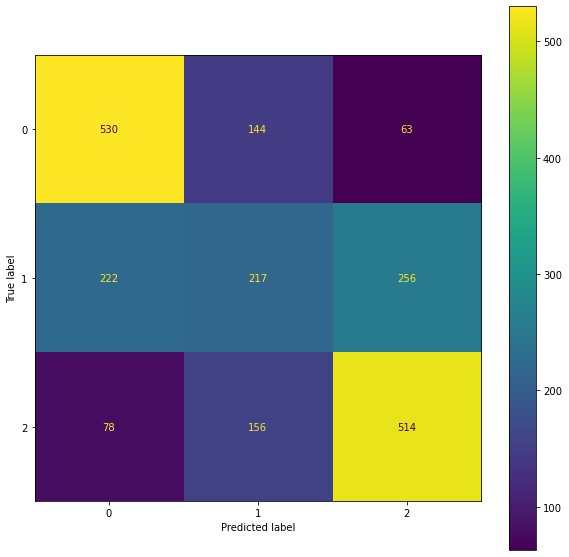

In [7]:
conmat = np.array(confusion_matrix(y_test, 
                                   logreg.predict(X_test), 
                                   labels=[0,1,2]))
print(classification_report(y_test,
                            logreg.predict(X_test), 
                            target_names=['0-11hr', '11-32hr', '32hours-7day']))

matrix_display = ConfusionMatrixDisplay(confusion_matrix=conmat, 
                                        display_labels=logreg.classes_)
matrix_display.plot()

figure = plt.gcf()
figure.set_size_inches(10, 10)
;

# Analysis

**Metrics**
- This model is 58% accurate in predicting the target class. This is 23% more than the baseline model with a probability of 35%. 
- The model had the highest precision in predicting the 1st class (0-11hours) followed closely by the 3rd class (32hours-7days). 
- the f1 score (harmonic mean of precision and recall) for the 2nd class was roughly half of either the 1st or 3rd classes. 

**Coefficients**
- The largest coefficient for all three classes was a state. 
    - coeffs_0: Pennsylvania, coeffs_1:Tennessee, coeffs_2:New Mexico
- `aircraft_2`  and `aircraft_1` were one of the largest coefficients for the 1st and 3rd classes respectively. These features indicate that there were two or one type(s) of aircrafts involved in the SAR mission. 
- `number_volunteers` was was also one of the largest coefficient for both the 1st and 3rd class. 

**Conclusion**
I binned the target total_hours into three mostly equally distributed classes. This increased the model's ability to predict the 2nd class, but ultimately reduced the accuracy of the model. This model is 3% less accurate than the Random Forest model. I would recommend implementing this model into production verses the Random Forest model soley due to the fact that it is more humanly interprettable and could give further insight into which facters are important in determing the time it takes to search for and rescue a victim. 